Esta fase de la metdologia consiste en extraer el valor de los datos desarrollando un modelo que aprenda de los patrones en estos.

* El diagrama en cuestion de esta fase esta a continuacion:

![Imagen_mapa](imagen_modelado_general.png)

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator #generator de imagenes
from sklearn.utils import class_weight
from sklearn.metrics import classification_report

In [2]:
tf.keras.backend.clear_session()

In [3]:
tf.random.set_seed(42)#semilla 42, para la reproducibilidad de resultados

### Canalizacion de datos

* Preparamos la canalizacion de datos, a partir de las imagenes del disco.

In [4]:
train_datagen=ImageDataGenerator(
            rescale=1.0/255, #escalamos los datos en rangos de [-1,1] El modelo MobileNetv2 espera esta configuracion
            rotation_range = 45,
            zoom_range = 0.2,
            shear_range = 0.2,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            horizontal_flip=True,
            vertical_flip = True,
            fill_mode = 'nearest'
        )
#sobre los datos de validacion y test no se hace ningun aumento de datos.
validation_datagen=ImageDataGenerator(rescale=1.0/255) #escalamiento de validacion a un rango de [0,1]
test_datagen=ImageDataGenerator(rescale=1.0/255)       #escalamiento de test a un rango de [0,1]

In [5]:
#definimos las rutas para el acceso a los datos
train_path="../input/datasetscovidsplit/Datasets/train"
validation_path="../input/datasetscovidsplit/Datasets/val"
test_path="../input/datasetscovidsplit/Datasets/test"

#creamos los generadores de datos a partir de los flujos de informacion
BATCH_SIZE=32 #tamaño del lote que se ira pasando poco a poco
IMAGE_SIZE=(256,256)

train_generator=train_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

validation_generator=validation_datagen.flow_from_directory(
    validation_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator=test_datagen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 15238 images belonging to 4 classes.
Found 1694 images belonging to 4 classes.
Found 4233 images belonging to 4 classes.


### Tecnica para el tratamiento de datos Desbalaceados. Focal Loss Categorical

* Para ello personalizaremos una funcion de costo
* En nuestro caso trabajamos con imagenes, y tenemos la opcion de tratar este desbalanceo **penalizando los pesos de las clases** mayoritarias a favor de las clases minoritarias.


In [6]:

def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002
        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]
        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})
        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

### Selección de tecnicas de Modelado

Al tratarse de un problema de clasificacion de imagenes entre los posibles candidatos tenemos:

* MultiLayer Pereptron: Red neuronal de capas densamente conectadas
* Convolutional Neuronal Network: Red neuronal convolucional.
* Modelos de machine learning clasico (Maquinas de soporte vectorial, arboles de decision e impulso, etc.)

Escogi la red neuronal convolucional porque **aprende de patrones locales** como rasgos pequeños y en bloques de informacion, mientras que el **MLP** aprende de patrones especficos, e decir de todo el espacio de entrada en general.


### Construcción de la arquitectura del modelo

* Para la construccion de la arquitectura crearemos un modelo desde 0 con una arquitectura de red neuronal solida.


Una vez obtenidos la arquitectura del modelo
* Generando **Callbacks** para detener el entrenamiento cuando no se tienen buenos resultados


In [7]:
#cuando la funcion de perdida ya no mejora en los datos de validacion.
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=10,
                                                mode="min",
                                                restore_best_weights=True) 
model_checkpoint=tf.keras.callbacks.ModelCheckpoint("base_model_best_check.h5",save_best_only=True)
n_epochs=100

# Aplicación de Transfer Learning usando DenseNet169 y tecnica de anti-desbalanceo Focal Loss Categorical

* Se escogio la arquitectura DenseNet169 por tener un mayor precision sobre el conjunto de datos Image.net en la que fue entrenado.

In [9]:
INPUT_SHAPE=(256,256,3)
BASE_LEARNING_RATE=0.001
def build_model_transferLearning():
    dense_net169=tf.keras.applications.DenseNet169(
                weights="imagenet",
                input_shape=INPUT_SHAPE,
                include_top=False
            )
    #descongelamos algunas capas
    dense_net169.trainable=True
    for layer in dense_net169.layers:
        if 'conv5' in layer.name:
            layer.trainable=True
        else:
            layer.trainable=False
    #creamos el modelo
    inputs=tf.keras.Input(shape=INPUT_SHAPE)
    x=dense_net169(inputs)
    x=tf.keras.layers.Flatten()(x)
    
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.Dense(256,activation="relu")(x)
    x=tf.keras.layers.Dropout(0.4)(x)
    
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.Dense(128,activation="relu")(x)
    x=tf.keras.layers.Dropout(0.4)(x)
    
    outputs=tf.keras.layers.Dense(4,activation="softmax")(x)
    
    model=tf.keras.Model(inputs,outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LEARNING_RATE),
        loss=focal_loss(alpha=1.0),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.Recall(name="recall")    
        ]
    )
    return model

In [10]:
transfer_model=build_model_transferLearning()

51879936/51877672 [==============================] - 0s 0us/step


In [11]:
transfer_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
densenet169 (Functional)     (None, 8, 8, 1664)        12642880  
_________________________________________________________________
flatten (Flatten)            (None, 106496)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 106496)            425984    
_________________________________________________________________
dense (Dense)                (None, 256)               27263232  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024  

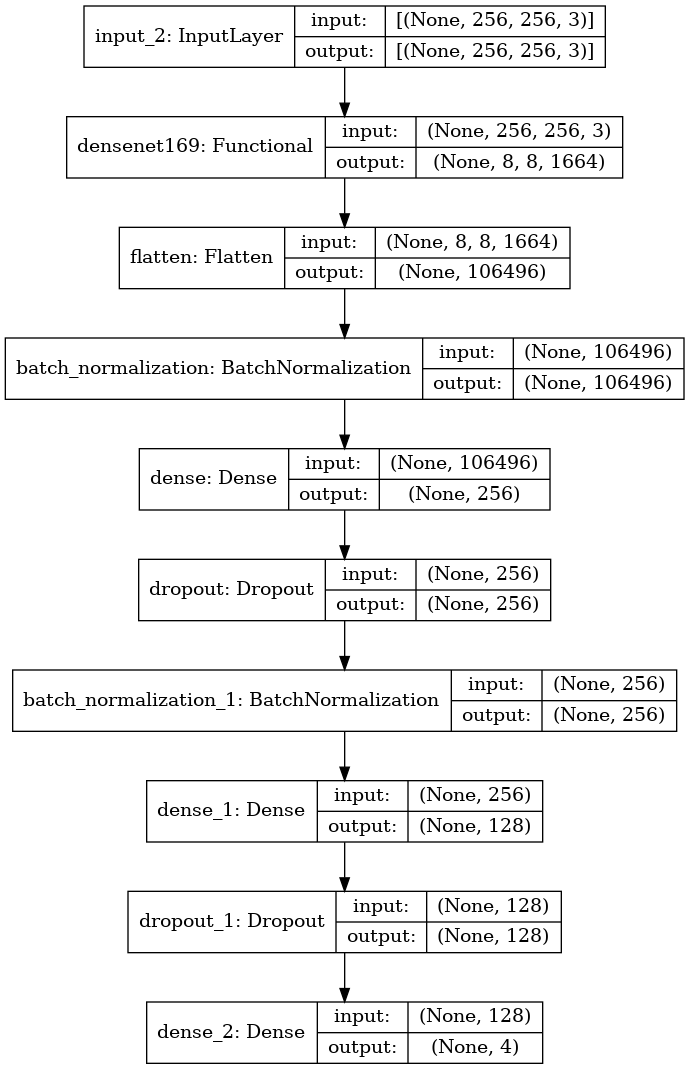

In [12]:
plot_model(transfer_model,"transfer_densenet.png",show_shapes=True)

#### ENTRENAMIENTO DEL MODELO

* El entrenamiento se realiza en **100 epocas**, un generador de datos de entrenamiento, un generador de datos de validacion, 2 callbacks para detener el entrenamiento de manera temprana en caso no se obtengan buenos resultados en base a la funcion de perdida en los datos de validacion durante 10 epocas consecutivas, y otra para guardar por puntos el mejor modelo obtenido hasta el momento.

In [13]:
transfer_model=build_model_transferLearning()
history_model=transfer_model.fit(
                    train_generator,
                    epochs=n_epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples//validation_generator.batch_size,
                    callbacks=[early_stopping,model_checkpoint],
                    #class_weight=class_weights,#penalizacion de pesos para el balanceo,
                    workers=8
            )

Epoch 1/100
477/477 [==============================] - 275s 533ms/step - loss: 0.4775 - accuracy: 0.6926 - recall: 0.6193 - val_loss: 0.2649 - val_accuracy: 0.7458 - val_recall: 0.6556
Epoch 2/100
477/477 [==============================] - 258s 534ms/step - loss: 0.2037 - accuracy: 0.8088 - recall: 0.7503 - val_loss: 0.1235 - val_accuracy: 0.8690 - val_recall: 0.8203
Epoch 3/100
477/477 [==============================] - 256s 529ms/step - loss: 0.1550 - accuracy: 0.8496 - recall: 0.8049 - val_loss: 0.1211 - val_accuracy: 0.8804 - val_recall: 0.8462
Epoch 4/100
477/477 [==============================] - 253s 525ms/step - loss: 0.1333 - accuracy: 0.8639 - recall: 0.8271 - val_loss: 0.1103 - val_accuracy: 0.8852 - val_recall: 0.8570
Epoch 5/100
477/477 [==============================] - 257s 531ms/step - loss: 0.1239 - accuracy: 0.8710 - recall: 0.8356 - val_loss: 0.1095 - val_accuracy: 0.9002 - val_recall: 0.8762
Epoch 6/100
477/477 [==============================] - 256s 531ms/step - lo

In [14]:
transfer_model.save("./tranferlearning_densenet169_with_balanced_focal_loss.h5")

In [15]:
def plot_metrics(history,metrics=[]): #retorna una lista de tuplas
    fig,axes=plt.subplots(1,len(metrics))
    fig.set_size_inches(15,5)
    graph=pd.DataFrame(history)
    for i,ax in enumerate(axes.flat):
        graph[list(metrics[i])].plot(kind="line",style="-",ax=ax)
        ax.set_title(" VS ".join(list(metrics[i])))
        ax.grid(True)
    plt.show()

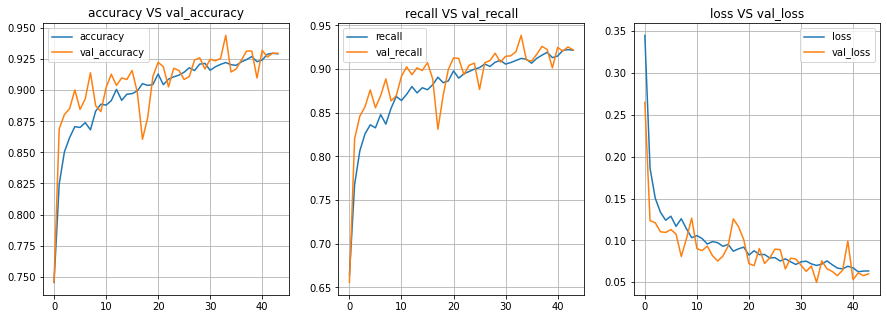

In [18]:
metrics=[("accuracy","val_accuracy"),("recall","val_recall"),("loss","val_loss")]
plot_metrics(history_model.history,metrics=metrics)

In [20]:
#obtenemos el numero de epocas donde se detuvo y lo configuramos como un epoch inicial para el siguiente
#entrenamiento
EPOCH_STOP=len(history_model.epoch)
print("El modelo se entreno en",EPOCH_STOP,"Epochs")

El modelo se entreno en 44 Epochs


* El entrenamiento del modelo se detuvo en 47 epochs lo que nos dice que la funcion de perdida en la data de validacion no mejoro por 10 epochs consecutivos, probablemente, ya no mejore para futuras epocas.

Ahora veamos el rendimiento del modelo base en los datos de entrenamiento y validacion

In [21]:
transfer_model.evaluate(train_generator)

477/477 [==============================] - 240s 504ms/step - loss: 0.0511 - accuracy: 0.9396 - recall: 0.9339


[0.05107705295085907, 0.9396246075630188, 0.9339151978492737]

In [22]:
transfer_model.evaluate(validation_generator)

53/53 [==============================] - 27s 507ms/step - loss: 0.0562 - accuracy: 0.9298 - recall: 0.9238


[0.056237637996673584, 0.9297520518302917, 0.9238488674163818]

* Mostramos la matriz de confusion en los datos de entrenamiento y validacion

Para el conjunto de entrenamiento

In [23]:
y_true=train_generator.classes
predictions=transfer_model.predict(train_generator)
y_pred=np.argmax(predictions,axis=1)

In [24]:
print("Indices de clase")
for idx,clase in train_generator.class_indices.items():
    print(idx,":",clase)

Indices de clase
COVID : 0
Lung_Opacity : 1
Normal : 2
Viral Pneumonia : 3


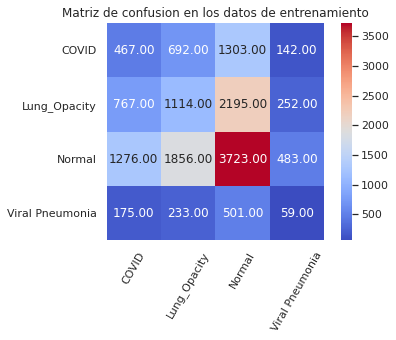

In [25]:
#obtenemos la matriz de confusion de sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
classes=train_generator.class_indices.keys()
mat_train=confusion_matrix(y_true,y_pred)
sns.heatmap(mat_train,square=True,annot=True,fmt="0.2f",cmap="coolwarm",xticklabels=classes,yticklabels=classes)
plt.xticks(rotation=60)
plt.title("Matriz de confusion en los datos de entrenamiento")
plt.show()

* Reporte de clasificacion para el conjunto de entrenamiento

In [26]:
report=classification_report(y_true,y_pred,target_names=list(train_generator.class_indices.keys()))
print(report)

                 precision    recall  f1-score   support

          COVID       0.17      0.18      0.18      2604
   Lung_Opacity       0.29      0.26      0.27      4328
         Normal       0.48      0.51      0.49      7338
Viral Pneumonia       0.06      0.06      0.06       968

       accuracy                           0.35     15238
      macro avg       0.25      0.25      0.25     15238
   weighted avg       0.35      0.35      0.35     15238



* Para el conjunto de validacion

In [27]:
y_true=validation_generator.classes
predictions=transfer_model.predict(validation_generator)
y_pred=np.argmax(predictions,axis=1)

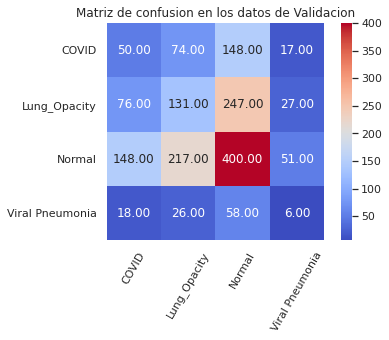

In [28]:
classes=validation_generator.class_indices.keys()
mat_val=confusion_matrix(y_true,y_pred)
sns.heatmap(mat_val,square=True,annot=True,fmt="0.2f",cmap="coolwarm",xticklabels=classes,yticklabels=classes)
plt.xticks(rotation=60)
plt.title("Matriz de confusion en los datos de Validacion")
plt.show()

* Reporte de clasificacion para los datos de validacion

In [29]:
report=classification_report(y_true,y_pred,target_names=list(train_generator.class_indices.keys()))
print(report)

                 precision    recall  f1-score   support

          COVID       0.17      0.17      0.17       289
   Lung_Opacity       0.29      0.27      0.28       481
         Normal       0.47      0.49      0.48       816
Viral Pneumonia       0.06      0.06      0.06       108

       accuracy                           0.35      1694
      macro avg       0.25      0.25      0.25      1694
   weighted avg       0.34      0.35      0.34      1694



### RESULTADOS FINALES: MODELO TRANFER LEARNING CON PERDIDA FOCAL PARA EL BALANCEO DE CLASES
* El modelo base ha obtenido un puntaje de accuracy **ACC=93%** y recall **RECALL=93.39%** en el **conjunto de entrenamiento**.

* El modelo ha obtendio un puntaje de accuracy **ACC=92.98%** y recall **RECALL=92.38%** en el **conjunto de validacion**.

**IMPORTANTE**: El modelo ha alcanzado  equilibrio entre los datos de entrenamiento y validacion, lo que siginifica que es un modelo final con aproximadamente 93% de precision. Este modelo pasará a la **Fase de evaluación del modelo**.